In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Input, Conv2DTranspose, MaxPool2D, Activation, BatchNormalization, Concatenate
from keras.utils.vis_utils import plot_model

2022-11-30 17:50:25.038230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 17:50:26.376350: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rpomorski/Projekty/Equinity/venv/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-10.1/lib64:
2022-11-30 17:50:26.376511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rpomorski/Pro

In [2]:
img = cv2.imread(r"C:\Users\RemigiuszPomorski\Desktop\Projekty\Equinity\data\ogon_w_gorze\ogon_w_gorze (1).jpeg", 0)
#plt.imshow(img)

[ WARN:0@2.608] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('C:\Users\RemigiuszPomorski\Desktop\Projekty\Equinity\data\ogon_w_gorze\ogon_w_gorze (1).jpeg'): can't open/read file: check file path/integrity


In [6]:
def conv_layer(input, n_filters):
    x = Conv2D(n_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x  

def conv_block(input, n_filters):
    x = conv_layer(input, n_filters)
    x = conv_layer(x, n_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

def up_sumple_conv_block(input, skip_features, n_filters):
    x = Conv2DTranspose(n_filters, (2,2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_layer(x, n_filters)
    x = conv_layer(x, n_filters)
    return x

def create_UNet(img_shape):
    input = Input(img_shape)
    s1, x = conv_block(input, 64)
    s2, x = conv_block(x, 128)
    s3, x = conv_block(x, 256)
    s4, x = conv_block(x, 512)
    
    #most
    x = conv_layer(x, 1024)
    x = conv_layer(x, 1024)
    
    x = up_sumple_conv_block(x, s4, 512)
    x = up_sumple_conv_block(x, s3, 256)
    x = up_sumple_conv_block(x, s2, 128)
    x = up_sumple_conv_block(x, s1, 64)
    outputs = Conv2D(3, 1, padding = "same", activation = "softmax")(x)
    model = tf.keras.Model(inputs=input, outputs = outputs)
    return model

def decoder_up_sample_conv_block(input, n_filters):
    x = conv_layer(input, n_filters)
    x = conv_layer(x, n_filters)
    p = Conv2DTranspose(n_filters, (2,2), strides=2, padding="same")(x)
    return x, p

def decoder_conv_block(input, skip_features, n_filters):
    x = MaxPool2D((2,2))(input)
    x = Concatenate()([x, skip_features])
    x = conv_layer(x, n_filters)
    x = conv_layer(x, n_filters)
    return x

def create_RevUNet(img_shape):
    input = Input(img_shape)
    s1, x = decoder_up_sample_conv_block(input, 64)
    s2, x = decoder_up_sample_conv_block(x, 128)
    s3, x = decoder_up_sample_conv_block(x, 256)
    s4, x = decoder_up_sample_conv_block(x, 512)
    
    #most
    x = conv_layer(x, 1024)
    x = conv_layer(x, 1024)
    
    x = decoder_conv_block(x, s4, 512)
    x = decoder_conv_block(x, s3, 256)
    x = decoder_conv_block(x, s2, 128)
    x = decoder_conv_block(x, s1, 64)
    outputs = Conv2D(1, 1, padding = "same", activation = "softmax")(x)
    model = tf.keras.Model(inputs=input, outputs = outputs)
    return model

UNet_model = create_UNet((256,256,1))
reverse_UNet = create_RevUNet((256,256,3))

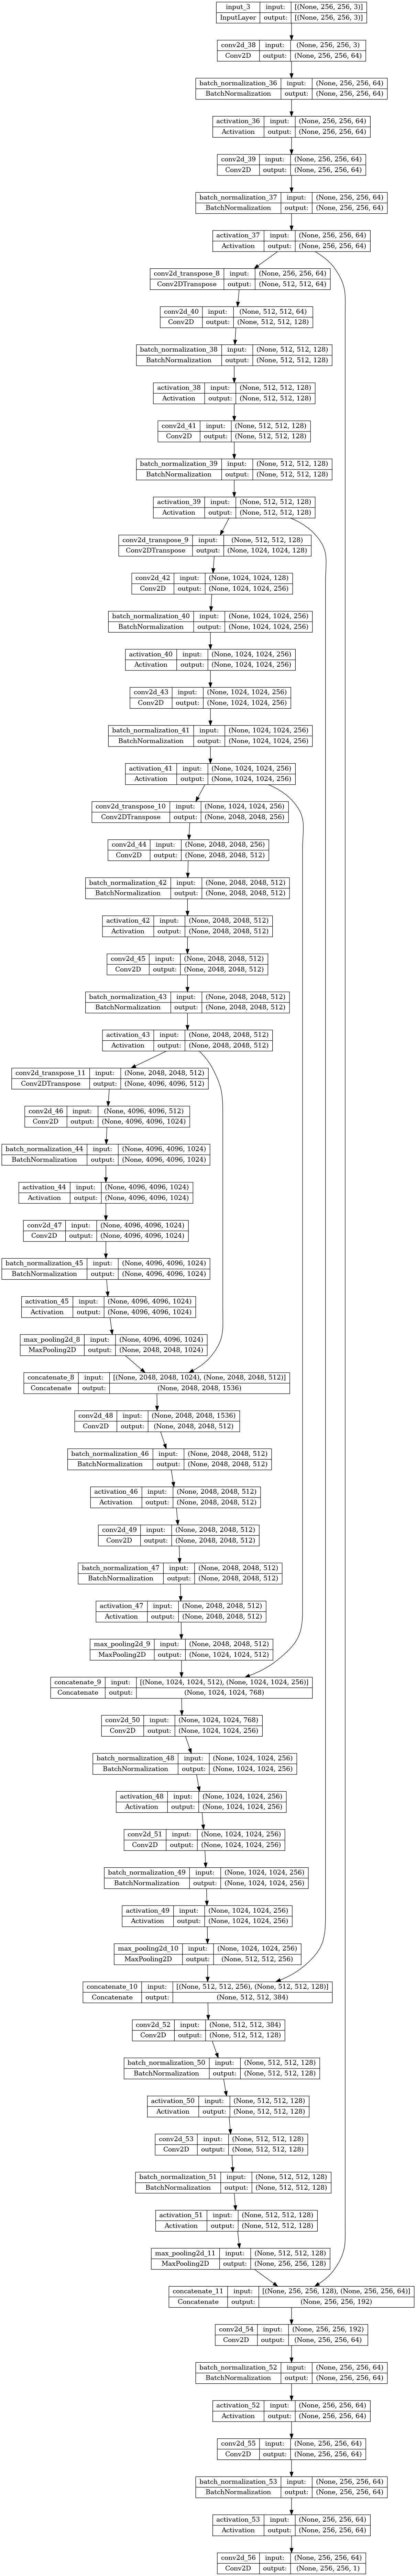

In [8]:
plot_model(reverse_UNet, to_file='RevU_Net.png', show_shapes=True)

In [10]:
!pip install pydot

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
You should consider upgrading via the '/home/rpomorski/Projekty/Equinity/venv/bin/python -m pip install --upgrade pip' command.
